## DATA 22100: NLP and Sentiment Analysis Example

In this notebook we will be utilizing NLP techniques to analyze Elon Musk's tweets. We will be discussing topic modeling and sentiment analysis, and at the end we will develop a trading strategy based on the sentiment of his tweets for TSLA stock.

Run the following set up code:

In [2]:
# Set up codes

import pandas as pd
import numpy as np
import gensim
import spacy 
from spacy.lang.en.stop_words import STOP_WORDS
import pyLDAvis 
import pyLDAvis.gensim_models as gensimvis
import re
import string
import operator
import warnings
from collections import defaultdict
import pprint
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [47]:
# load data
df = pd.read_csv("TweetsElonMusk.csv")
df['Date'] = df.date.apply(lambda x: x[:-5])
df = df.drop(columns=['date'])

In [48]:
df.head()


,texts,Date
0,Dragon spacecraft &amp; Falcon 9 rocket https...,2021-04-17 08:46:56
1,@WhatsupFranks Great progress by Tesla team,2021-04-17 07:51:09
2,"If we make life multiplanetary, there may come...",2021-04-17 07:46:34
3,@neuralink @shivon Great review! Neuralink is ...,2021-04-17 07:16:45
4,Everything to the moon!,2021-04-17 04:37:48


In [49]:
len(df)

12516

For this next cell, please go to your terminal and enter the following in order to install the language model:

python -m spacy download en_core_web_sm

In [9]:
import en_core_web_sm
spacy_nlp   = en_core_web_sm.load()

# Part I. Data cleaning and EDA

In [50]:
def clean_tweets(tweet):
    """
    Tokenize and lemmatize an input tweet
    
    Input:
        Tweet: string type
    Output:
        A list containing tokens
    """
    tweet       = re.sub('&amp;', ' ',tweet)
    tweet       = emoji_pattern.sub(r' ', tweet)
    
    word_tokens = spacy_nlp(tweet)
    tokens      = []
    
    for w in word_tokens:
        if not w.is_stop: # not stop words
            s   = w.text.lower()
            s   = re.sub(r'^[@#]', '', s)
            s   = re.sub(r'[^a-zA-Z0-9_]+$', '', s)
            s   = re.sub(r'https?:\S*', '', s)
            s   = re.sub(r'[-,#()@=!\"\'\?\/:]+', ' ', s)
            
            #replace consecutive non-ASCII characters with a space
            s   = re.sub(r'[^\x00-\x7F]+',' ', s)
            tokens += s.split()
    text = " ".join(tokens)

    word_tokens    = spacy_nlp(text)
    filtered_tweet = []
    for w in word_tokens:
        if not w.is_stop:
            if w.lemma_ != "-PRON-":
                s = w.lemma_.lower()
            else:
                s = w.lower_
            s = s.strip('-')
            if len(s) <= 1:
                continue
            if re.match(r'^[a-zA-Z_\.]+$', s):
                filtered_tweet.append(s)
    
    return filtered_tweet

In [51]:
#Emoji patterns
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

Test if the tokenization works well.

In [53]:
#Test tokenization
for i in range(20):
    print(clean_tweets(df.loc[i]["texts"]))


['dragon', 'spacecraft', 'falcon', 'rocket']
['whatsupfrank', 'great', 'progress', 'tesla', 'team']
['life', 'multiplanetary', 'come', 'day', 'plant', 'animal', 'die', 'earth', 'alive', 'mar']
['neuralink', 'shivon', 'great', 'review', 'neuralink', 'open', 'working', 'neuroscientist', 'advance', 'field', 'short', 'term', 'goal', 'address', 'brain', 'spine', 'problem', 'ultimate', 'goal', 'symbiosis', 'human', 'machine', 'intelligence']
['moon']
['honor', 'nasaartemis', 'team']
['nasa', 'rule']
[]
['austin', 'rock']
['berlin']
['limited', 'production', 'model', 'year', 'high', 'volume', 'year']
['drive', 'cybertruck', 'site', 'build']
['life', 'multiplanetary', 'mar']
['erdayastronaut', 'thesheetztweetz', 'yeah', 'fully', 'mobile', 'later', 'year', 'use', 'rv', 'truck', 'motion', 'need', 'satellite', 'launch', 'achieve', 'compete', 'coverage', 'key', 'software', 'upgrade']
['thesheetztweetz', 'accurate', 'service', 'uptime', 'bandwidth', 'latency', 'improve', 'rapidly', 'probably', 'bet

In [54]:
# bag-of-words (BOW) model
processed_docs = []

for t in df['texts']:
    try: 
        processed_docs.append(clean_tweets(t))
    except: pass


# create a dictionary for all tweets
dictionary     = gensim.corpora.Dictionary(processed_docs)

# create word bow for all tweets, this can help us record the times of each word appeared in each tweet.
bow_corpus     = [dictionary.doc2bow(doc) for doc in processed_docs]

In [55]:
# Running LDA using Bag of Words
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,id2word=dictionary,num_topics=8, passes=20,random_state = 1,workers=3)

In [56]:
# Display the topic models
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vis_data1 = gensimvis.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(vis_data1)

In [57]:
#Running LDA using TF-IDF

#Create tf-idf model object using models.TfidfModel on bow_corpus and save it to 'tfidf'
tfidf           = gensim.models.TfidfModel(bow_corpus)

#apply transformation to the entire corpus and name it 'corpus_tfidf'
corpus_tfidf    = tfidf[bow_corpus]
tfidf_lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, 
                                             passes=20, random_state=np.random.RandomState(20800))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    vis_data_tf_idf   = gensimvis.prepare(tfidf_lda_model, corpus_tfidf, dictionary)

pyLDAvis.display(vis_data_tf_idf)

In [66]:
def sentiment_analyzer(sentences, pos_cutoff = 0.7, neg_cutoff = -0.7):
    """
    Given a list of tweets, return those that contain strong positive/negative sentiments
    Args:
        sentences: a list containing the indices of tweets in text_data
        pos_cutoff: tweets with sentiment scores >= pos_cutoff are classified as positive
        neg_cutoff: tweets with sentiment scores <= neg_cutoff are classified as negative
    Returns:
        pos: a list containing the indices of tweets that are classified as positive
        neg: a list containing the indices of tweets that are classified as negative
    """
    analyser  = SentimentIntensityAnalyzer()
    pos, neg  = [], []
    for i in sentences:
        score = analyser.polarity_scores(tweets[i])
        
        if score['compound']   >= pos_cutoff: # positive comments
            pos.append(i)
        elif score['compound'] <= neg_cutoff: # negative comments
            neg.append(i)
    return (pos, neg)

In [67]:
tweets = df['texts']
dates = df['Date']

In [68]:
# lists containing indices for positive tweets and negative tweets resp.
pos, neg = sentiment_analyzer(np.arange(len(tweets)))

In [70]:

# Positive sentence example
tweets[pos[1]]

'🚀🖤💫 NASA Rules!! 💫🖤🚀'

In [72]:


# Negative sentence example

tweets[neg[4]]


'@vincent13031925 @JonErlichman I put in my last money, even though I thought we would still fail. But, it was either that or certain death for Tesla. Extremely difficult to raise money for an electric car startup (considered super quirky back then), while stalwarts like GM &amp; Chrysler were going bankrupt.'

## STOCK TRADING WITH SENTIMENT ANALYSIS

In [73]:
# Load TSLA return data
tsla =  pd.read_csv("TSLA.csv")
tsla['CLOSEPRC'] = 0.5 * (tsla.BID + tsla.ASK)
tsla.date =tsla.date.apply(lambda x: str(x))
tsla.date = tsla.date.apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:])
tsla.head()

,PERMNO,date,TICKER,BIDLO,ASKHI,PRC,VOL,RET,BID,ASK,OPENPRC,CLOSEPRC
0,93436,2010-06-29,TSLA,17.54,25.0000,23.89,19088009,C,23.73,23.90,19.00,23.815
1,93436,2010-06-30,TSLA,23.30,30.4192,23.83,17607305,-0.002511,23.61,23.75,25.79,23.680
2,93436,2010-07-01,TSLA,20.27,25.9200,21.96,8379501,-0.078473,21.85,21.90,25.00,21.875
3,93436,2010-07-02,TSLA,18.71,23.1000,19.20,5255750,-0.125683,19.15,19.25,23.00,19.200
4,93436,2010-07-06,TSLA,15.83,20.0000,16.11,7011230,-0.160938,15.98,16.04,20.00,16.010


In [74]:
def time_range(date):
    """
    Given a date, return the market opening time and closing time on that day
    Args:
        date: a string of the format 'mm/dd/yy hh:mm'
    Returns:
        a tuple: '(mm/dd/yy-09:30:00, mm/dd/yy-16:00:00)'
    """
    return (pd.Timestamp(pd.to_datetime(date).date()) + pd.Timedelta('09:30:00'), pd.Timestamp(pd.to_datetime(date).date()) + pd.Timedelta('16:00:00'))

Trading strategy. 


For positive sentiment signals, the trading strategy is:
+ (1)if signal occurs before market opens: buy at open and sell at close;
+ (2)if signal occurs during market hours: buy at close and sell at tomorrow’s close
+ (3)if signal occurs after hours: buy at tomorrow’s open and sell at tomorrow’s close

For negative sentiment signals, the trading strategy is:
+ (1)if signal occurs before market opens: sell at open and return to 100% SPY exposure at close
+ (2)if signal occurs during market hours: sell at close and return to 100% SPY exposure at tomorrow’s close
+ (3)if signal occurs after hours: sell at tomorrow’s open and return to 100% SPY exposure at tomorrow’s close



In [75]:
def trade(signals, positive=True):
    """
    Given a list of signals, compute the profits gained.
    For positive sentiment signals, the trading strategy is:
        (1)if signal occurs before market opens: buy at open and sell at close;
        (2)if signal occurs during market hours: buy at close and sell at tomorrow’s close
        (3)if signal occurs after hours: buy at tomorrow’s open and sell at tomorrow’s close
    For negative sentiment signals, the trading strategy is:
        (1)if signal occurs before market opens: sell at open and return to 100% SPY exposure at close
        (2)if signal occurs during market hours: sell at close and return to 100% SPY exposure at tomorrow’s close
        (3)if signal occurs after hours: sell at tomorrow’s open and return to 100% SPY exposure at tomorrow’s close
    Args:
        signals: a list containing the time ('mm/dd/yy hh:mm') when a signal occurred (aka. tweet was published)
        positive: boolean. True means the input are all positive sentiment signals; False means negative sentiment signals. 
    Returns:
        No return value. Modifications are done on the dict 'profits'
    """
    for s in signals:
        op, ed = time_range(s)
        x      = str(pd.to_datetime(s).date())
        #Signal occurs before market opens:
        if pd.Timestamp(s) < op and len(tsla.loc[tsla["date"] == x]) > 0:
            if positive:
                #buy at open and sell at close
                p = tsla.loc[tsla["date"] == x]["CLOSEPRC"].values[0] - tsla.loc[tsla["date"] == x]["OPENPRC"].values[0]
            else:
                #sell at open and return to 100% SPY exposure at close
                p = tsla.loc[tsla["date"] == x]["OPENPRC"].values[0] - tsla.loc[tsla["date"] == x]["CLOSEPRC"].values[0]
            profits[x].append(p)
        else:
            t = pd.Timestamp(pd.to_datetime(s).date()) + pd.Timedelta('1 days') #next day
            y = str(pd.to_datetime(t).date())
            if len(tsla.loc[tsla["date"] == y]) > 0:
                #Signal occurs after hours:
                if pd.Timestamp(s) > ed:
                    if positive:
                        #buy at tomorrow’s open and sell at tomorrow’s close
                        p = tsla.loc[tsla["date"] == y]["CLOSEPRC"].values[0] - tsla.loc[tsla["date"] == y]["OPENPRC"].values[0]
                    else:
                        #sell at tomorrow’s open and return to 100% SPY exposure at tomorrow’s close
                        p = tsla.loc[tsla["date"] == y]["OPENPRC"].values[0] - tsla.loc[tsla["date"] == y]["CLOSEPRC"].values[0]
                # Signal occurs during market hours:
                elif len(tsla.loc[tsla["date"] == x]) > 0:
                    if positive:
                        #buy at close and sell at tomorrow’s close
                        p = tsla.loc[tsla["date"] == y]["CLOSEPRC"].values[0] - tsla.loc[tsla["date"] == x]["CLOSEPRC"].values[0]
                    else:
                        #sell at close and return to 100% SPY exposure at tomorrow’s close
                        p = tsla.loc[tsla["date"] == x]["CLOSEPRC"].values[0] - tsla.loc[tsla["date"] == y]["CLOSEPRC"].values[0]
                profits[y].append(p)

In [76]:
def find_signals(signals):
    """
    Given a list of signals, return the dates of their occurrences and the closing values of TSLA at the corresponding dates
    Args:
        signals: a list containing the time ('mm/dd/yy hh:mm') when a signal occurred (aka. tweet was published)
    Returns:
        time: a list containing the date ('mm/dd/yy') of each signal
        value: a list containing the closing values of TSLA at each day in time
    """
    time, value = [], []
    for s in signals:
        x = str(pd.to_datetime(s).date())
        if len(tsla.loc[tsla["date"] == x]) > 0:
            time.append(x)
            value.append(tsla.loc[tsla["date"] == x]["CLOSEPRC"].values[0])
    return (time, value)

In [77]:
# Initialize the profits, defalut = []

profits = defaultdict(list)

In [78]:
# Find the positive signals and negative signals and perform the trading respectively.

pos_time, neg_time = [df.iloc[i]["Date"] for i in pos], [df.iloc[i]["Date"] for i in neg]


trade(pos_time)
trade(neg_time, False)

In [79]:
time  = list(tsla["date"].values)
y1    = list(tsla["CLOSEPRC"].values)
y2    = [] 
start = 0
for t, v in zip(time, y1):
    start += np.mean(profits[t] if profits[t] else 0.0)
    y2.append(v + start)

In [80]:
# Get the buy and sell signals

buy, bval  = find_signals(pos_time)
sell, sval = find_signals(neg_time)

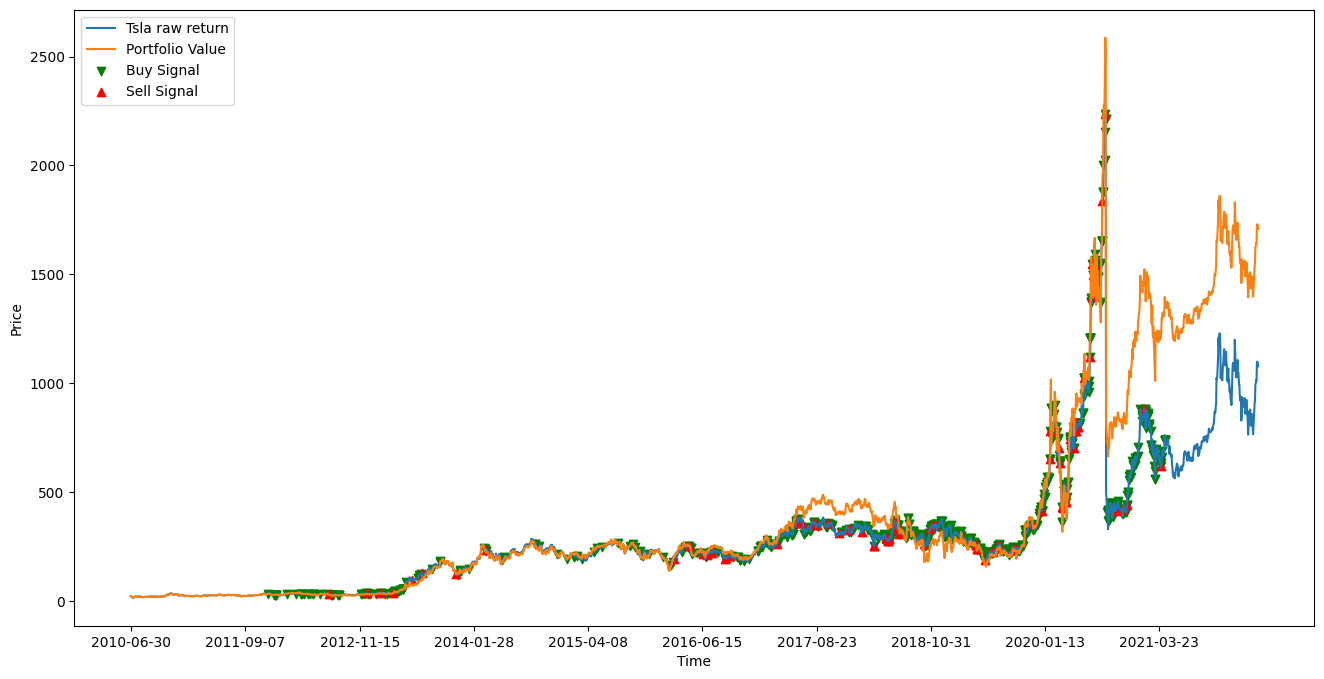

In [81]:
# Visualize the trading strategy

plt.figure(figsize = (16, 8))
plt.plot(time, y1, label = "Tsla raw return")
plt.plot(time, y2, label = "Portfolio Value")
plt.scatter(buy, bval, marker = 'v', c = "green", label = "Buy Signal")
plt.scatter(sell, sval, marker = '^', c = "red", label = "Sell Signal")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc = "upper left")

plt.xticks(range(1,2960,300))
plt.show()